### 1. Abstract:


### 2. Data Description:

Data consists of two text files, one for the reference molecule and another for the test molecules. Both files are in a mol2 format, further information can be found [here](https://chemicbook.com/2021/02/20/mol2-file-format-explained-for-beginners-part-2.html)

Because we are interested only in the geometrical properties of each molecule, only two tables interest us:
1. Euclidean coordinates of each atom, which are presented in the first table, where columns 0 is the atom index, and columns 2,3 and 4, represent x, y, z coordinates respectively.

2. Bonds between each atom, which are represented in the second table, where column 1 is the index of origin atom and column 2 is the index of destination atom.

Hydrogen atoms were ignored during the project because they do not have an impact on the molecules geometry (They can have only one bond)

### 3. Reserch goals:

1. Find similar molecules to the reference molecule.
2. Cluster the test molecules according to their similarity.


### 4. Similartiy definition:

Similarity is an abstract definition that requires some kind of quantiyfing to score the test molecules. Furthermore, because of the abstracness, the project is unsupervised.

Similarity was defiend as the euclidian distance between the features that were extracted for each molecules. The smaller the distance, the higher the similarity score.

### 5. General settings and utility Functions

In [2]:
# Only needed on google colab:
# !pip install matplotlib==3.5.2
# !pip install pyvista

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram
import pyvista as pv

In [4]:
# import warnings
# warnings.filterwarnings('ignore')

In [5]:
#if Runnong of colab:
# %matplotlib inline

#If running on jupyter:
%matplotlib notebook 

In [6]:
def read_molecules(file):
    
    """
    Extract the following for file object:
    1. List of the names of each molecule.
    2. List of 2D numpy arrays, each array contains a 2D array with n*4 size, where n = number of atoms (excluding Hydrogen).
        column 1 - Atom index
        Column 2 - x coordinate
        column 3 - y coordinate
        column 4 - z coordinate
    3. list of sub-lists, each sublist contains the hydrogen indexs        
    """
    
    names = []
    H_indexs = []
    
    molecules = []
    mol_counter = 0

    lines = iter(file)

    for line in lines:

        if line == '@<TRIPOS>MOLECULE\n':
            names.append(next(lines)[:-1])
            first_coord = True
            continue

        if line == '@<TRIPOS>ATOM\n':

            line = next(lines)
            
            H_idx = []
            
            while True:

                atom = line.split()[1][0]

                if atom == 'H':
                    H_idx.append(int(line.split()[0]))
                    line = next(lines)

                    if line == '@<TRIPOS>BOND\n':
                        H_indexs.append(H_idx)
                        break

                    else:
                        continue

                coord = np.float64([line.split()[i] for i in [0, 2, 3, 4]])
                
                if first_coord:
                    temp_coord = coord
                    first_coord = False

                else:
                    temp_coord = np.vstack((temp_coord, coord))
                    
                line = next(lines)

                if line == '@<TRIPOS>BOND\n':
                    H_indexs.append(H_idx)
                    
                    break;

            mol_counter +=1
            molecules.append(temp_coord)
             
    return names, molecules, H_indexs

In [7]:
def read_bonds(file, H_indexs):
    
    """
    Extract the a list (named 'bonds_idx') of sublists, each sublist contains a tuple (named bond) of 2 integers:
        1. Index of origin atom
        2. index of destination atom
    """
    
    bonds_idx = []
    mol_counter = 0
    lines = iter(file)

    for line in lines:
    
        if line == '@<TRIPOS>BOND\n':
            
            line = next(lines)
            first_bond = True
            
            while True:
                
                if (int(line.split()[1]) not in H_indexs[mol_counter]) and\
                    (int(line.split()[2]) not in H_indexs[mol_counter]):
                    
                    bond = (int(line.split()[1]), int(line.split()[2]))
                    
                    if first_bond:
                        temp_bonds = [bond]
                        first_bond = False
                    
                    else:
                        temp_bonds.append(bond)

                line = next(lines)
                
                if 'TRIPOS' in line or line == '\n':
                    break
                
            bonds_idx.append(temp_bonds)      
            mol_counter +=1
            
    return bonds_idx

In [8]:
def count_circles_edges(bonds_idx):
    
    num_circles = []
    num_edges = []
    edges_idx = []
    circles_idx = []
    chains = []
    i=-1
    for bond_idx in bonds_idx:
        i+=1
        origin = np.array([i[0] for i in bond_idx])
        target = np.array([i[1] for i in bond_idx])
        edge = []
        chain = 0
        
        mol_uniq_idx = np.unique(np.append(origin, target))
        
        while True:
            
            uniq, counter = np.unique(np.append(origin, target), return_counts = True)
            idx = []
            
            if 1 not in counter or len(uniq[counter == 1]) == 0:
                break
            
            else:
                chain +=1
                
            for bond in bond_idx:

                if bond[0] in uniq[counter == 1]:
                    
                    edge.append(bond[0])
                    
                    if bond[0] in origin:
                        
                        idx.append(np.where(origin == bond[0])[0][0])
                        
                    if bond[0] in target:
                        
                        idx.append(np.where(target == bond[0])[0][0])
                                                
                if bond[1] in uniq[counter == 1]:
                    
                    edge.append(bond[1])
                    
                    if bond[1] in origin:
                        
                        idx.append(np.where(origin == bond[1])[0][0])
                        
                    if bond[1] in target:
                        
                        idx.append(np.where(target == bond[1])[0][0])
            
            idx = np.unique(np.array(idx))
            origin = np.delete(origin, idx)
            target = np.delete(target, idx)
          
        edge = np.unique(edge)
        edges_idx.append(edge)
        circles_idx.append([i for i in mol_uniq_idx if i not in edge])
        
        if len(target) == 0:            #No circels
            num_circles.append(0)
            chains.append(chain*2)
            num_edges.append(len(mol_uniq_idx))
            
        elif all(counter == 2):         #only 1 circle:
            num_circles.append(1)
            chains.append(chain)
            num_edges.append(len(edge))
            
        elif all(counter <= 3):        #number of circle, but atoms are not in 2 different circles.
            num_circles.append((counter == 3).sum())
            chains.append(chain)
            num_edges.append(len(edge))
            
        else:                          #more than 1 circle, but atoms can be in 2 different circles.
            num_circles.append(-1)
            chains.append(chain)
            num_edges.append(len(edge))
         
    return num_circles, num_edges, circles_idx, edges_idx, chains

In [9]:
def sum_bonds_len(molecules, bonds_idx, atoms_idx, plane = 'XY'):
    
    """
    For each molecule, calculate the following:
    1. length - A list, where each object contains the sum of distances between each atom listed in atoms_idx, 
        on the specified plane, so if plane = 'XY', distance is calculated with x and y coordinates,
        ignore z coordinate.
        
    2. mean_length - Same as length, only with the mean of distances.
    3. var_length -  Same as length, only with the mean of distances.
    """
    
    length = []
    mean_length = []
    var_length = []
    
    if plane == 'XY':
        cols = [0,1,2]
    
    elif plane == 'XZ':
        cols = [0,1,3]
    
    elif plane == 'YZ':
        cols = [0,2,3]
    
    for i in range(len(molecules)):

        mol = np.take(molecules[i], cols, axis = 1)
        links = bonds_idx[i]
        atom_idx = atoms_idx[i]
        
        len_bond = []
        
        if len(atom_idx) ==  0:
            
            length.append(0)
            mean_length.append(0)
            var_length.append(0)
            
            continue

        for link in links:
            
            if link[0] in atom_idx or link[1] in atom_idx:
                
                len_bond.append(np.linalg.norm(mol[mol[:,0] == link[0]][:,1:][0] - mol[mol[:,0] == link[1]][:,1:][0]))

        length.append(np.sum(len_bond))
        mean_length.append(np.mean(len_bond))
        var_length.append(np.var(len_bond)) 
        
    return length, mean_length, var_length

In [58]:
def plot_3d_molecule(molecules, bonds_idx, data, mols_to_plot = 9, elev=30, azim=20, ref = []):
    
    """
    Plot a 3D sub-plots, each sub-plot illustrates a different molecule.
    
    While external_window is True, the plot will open in an external window and can be visualy rotated.
    
    *ref is meant for the reference molecule.
    ref[0] contains the x,y,z coordinates, ref[1] contanis the list of bonds. If ref is sent with the function call,
    both the test molecule and reference molecule are plotted on each subplot.
    """

    %matplotlib notebook
    
    sns.set_theme(font_scale = 1) 
    
    ncols = min(3, len(molecules))
    nrows = max(1,int(mols_to_plot/ncols))
    
    fig, ax = plt.subplots(nrows, ncols, subplot_kw={'projection': '3d'}, figsize = (13, int(mols_to_plot+3)))
    
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    if len(molecules) == 1:
        ax = np.expand_dims(ax, axis=0)
        ax = np.expand_dims(ax, axis=0)
    
    elif len(ax.shape) == 1:
        ax = np.expand_dims(ax, axis=0)
    
    i=0
    
    for row in range(nrows):
        
        for col in range(ncols):
            
            mol = molecules[i]
            
            xlim = 0
            ylim = 0
            zlim = 0

            for bond in bonds_idx[i]:
                
                x = [mol[mol[:,0] == bond[0]][0][1], mol[mol[:,0] == bond[1]][0][1]]
                y = [mol[mol[:,0] == bond[0]][0][2], mol[mol[:,0] == bond[1]][0][2]]
                z = [mol[mol[:,0] == bond[0]][0][3], mol[mol[:,0] == bond[1]][0][3]]
                
                ax[row, col].plot(x, y, z, color = 'orange', linewidth = 4, alpha = 1)

                xlim = max(xlim, *x)
                ylim = max(ylim, *y)
                zlim = max(zlim, *z, 1)

            if len(ref):
                
                mol = ref[0]

                for bond in ref[1]:

                    x = [mol[mol[:,0] == bond[0]][0][1], mol[mol[:,0] == bond[1]][0][1]]
                    y = [mol[mol[:,0] == bond[0]][0][2], mol[mol[:,0] == bond[1]][0][2]]
                    z = [mol[mol[:,0] == bond[0]][0][3], mol[mol[:,0] == bond[1]][0][3]]

                    ax[row, col].plot(x, y, z, color = 'k', linewidth = 2)
                    
            ax[row, col].set_title(f'{data.iloc[i,0]}')
            ax[row, col].set_box_aspect([ub - lb for lb, ub in (getattr(ax[row, col], f'get_{a}lim')() for a in 'xyz')])
            ax[row, col].view_init(elev=elev, azim=azim)
            
            i += 1

    plt.tight_layout(h_pad = 1, w_pad = .5)

    if len(ref):
        plt.suptitle('Orange = Molcule, black = Ref', y = 1.01)

    plt.show()

In [49]:
def calc_mean_of_var_per_num_clusters(data, distances, model, **params):
    
    """
    Iterate over number of clusters (2 to max_clusters). For each iteration, train a clustering model, and for each
    cluster, calculate the variance and maximum distance.
    Lastly, calculate the mean of variances.
    return np.array where column 1 is the number of cluster, columns 2 is the mean of variance.
    """
    
    mean_of_vars = []
    num_clusters = []

    max_clusters = min(100, len(data))
    
    for num in range(2, max_clusters):
        
        clf = model(num, **params)
        clusters = clf.fit_predict(X = data)
        
        num_var = []

        for cluster in np.unique(clusters):
            
            dist = distances[clusters == cluster]
            num_var.append(np.var(dist))
            
        mean_of_vars.append(np.mean(num_var))
        num_clusters.append(num)
        
    return np.column_stack([num_clusters, mean_of_vars])

In [12]:
def plot_var_vs_num_clusters(results, title):
    
    """
    Plot subplots, each subplot illustrates the variance (calculated with function
    calc_mean_of_var_per_num_clusters) as function of number of clusters.
    """
    
    %matplotlib inline
    sns.set_theme(font_scale = 1.4)
    fig, ax = plt.subplots(2, 2, figsize = (15,7), sharex = True, sharey = True)
    ax = ax.flatten()

    plt.suptitle(f'{title}\n\n', fontsize = 20)
    
    num_mols = [447, 1056, 299, 25]
    circs = [0, 1, 2, 'other']
    for i in range(4):

        ax[i].plot(results[i][:,0], results[i][:,1])
        ax[i].set_title(f'{circs[i]} Circles, {num_mols[i]} molecules')
        
        if i in [0,2]:
            ax[i].set_ylabel('Variance')

        if i in [2,3]:  
            ax[i].set_xlabel('Number of Clusters')
        
    plt.tight_layout()

In [13]:
def plot_violins(data_splits, distances, model, model_name):
    
    """
    Violin plot of clusters, where y axis illustrates the distance from the reference molecule.
    """
    
    %matplotlib inline
    sns.set_theme(font_scale = 1.5)
    
    num_plots = len(data_splits)
    
    fig, ax = plt.subplots(num_plots, 1, figsize = (20,20), sharex = True, sharey = True)
    ax = ax.flatten()
    
    circs = [0,1,2, 'Other']
    
    plt.suptitle(f'{model_name}', fontsize = 20, y = 0.95)

    for i in range(num_plots):
        
        cluster = model.fit_predict(data_splits[i])
        
        sns.violinplot(x = cluster, y = distances[i], ax = ax[i])
        ax[i].set_title(f'{circs[i]} Circles, {len(data_splits[i])} Molecules')

        ax[i].set_ylabel('Variance')

        if i == len(ax)-1:  
            ax[i].set_xlabel('Number of Clusters')

In [14]:
def plot_dendrogram(model, **kwargs):
    
    """
    Plot dendrogram of Agglomerative Clustering
    """
    
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    
    plt.figure(figsize = (20,10))
    sns.set_theme(font_scale = 1.5)
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### 6. Read files, merge molecules data with reference molecule

In [15]:
#Colab:
path = r'/content/drive/MyDrive/Data Science/Molecule similarity'

# Jupyter:
path = r'C:\Users\eviatar_b\Downloads\Project'

In [16]:
#Read test molecules file:

with open(path + r'/AAAARN.mol2') as f:
    file = f.readlines()
    
names, molecules, H_indexs = read_molecules(file)
bonds_idx = read_bonds(file, H_indexs)

In [17]:
#Read reference molecule file:

with open(path + r'/ref.mol2') as f:
    file = f.readlines()
    
ref_name, ref_molecule, ref_H_indexs = read_molecules(file)
ref_bonds_idx = read_bonds(file, ref_H_indexs)

In [18]:
#Merging ref molecule data with test molecules data:

ref_name.extend(names)
names = ref_name
del ref_name

ref_molecule.extend(molecules)
molecules = ref_molecule
del ref_molecule

ref_H_indexs.extend(H_indexs)
H_indexs = ref_H_indexs
del ref_H_indexs

ref_bonds_idx.extend(bonds_idx)
bonds_idx = ref_bonds_idx
del ref_bonds_idx

In [19]:
data = pd.DataFrame({'molecule_name': names})

### 7. PCA on molecules:

In it's current state, the x, y, z coordinates of each molecule are not necessarily aligned. This can cause a bias when extracting features, especially if the misaslighnment is significant. 

Furthermore, it will be difficult to visually compare molecules to the reference molecule.

To overcome the problem, I implemented PCA on each molecule seperatly, to merge the center of each molecule and rotate the axes in such way that the highest variance will be on X axis, second on Y axis, and last of Z axis.

This insures that when we will extract geometrical features, the highest variance will allways be on XY plane.

In [20]:
pca = PCA(n_components = 3)
molecules_pca = []

for i in range(len(molecules)):
    
    mol = pca.fit_transform(X = molecules[i][:, 1:])
    molecules_pca.append(np.concatenate([molecules[i][:,0].reshape(-1,1), mol], axis = 1))

### 8. Feature extraction

The data, in it's current state, is not suited for clustering models, which require a tabular form. 
Therefore we must extract feature that have a significant geometrical properties, that can distinguish one molecule from the other.

The following plot illustrate 3 distinguishable properties that were used for extracting features.

Note - All plots can be **rotated** with mouse scroll (Does not work on google colab)

<IPython.core.display.Javascript object>


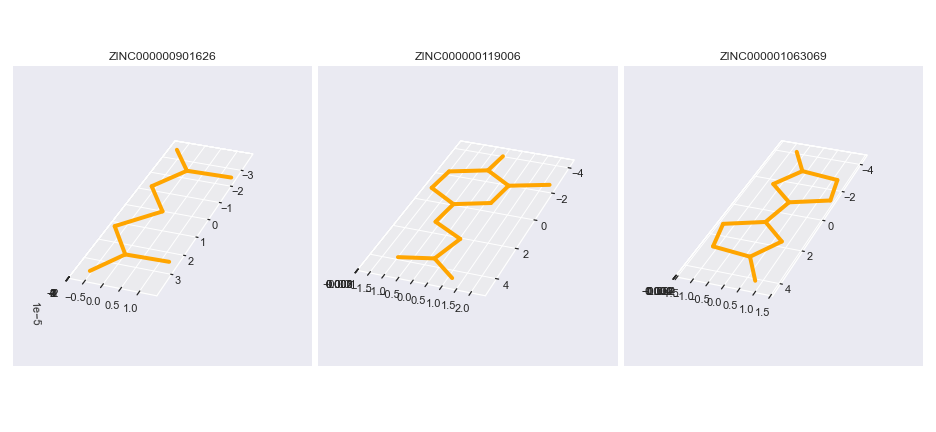

In [65]:
exmaple_mols = [400, 208, 1001]
plot_3d_molecule([molecules_pca[i] for i in exmaple_mols],
                 [bonds_idx[i] for i in exmaple_mols],
                 data.iloc[exmaple_mols,:],
                 len(exmaple_mols),
                 elev = 30,               #change azim and elev to rotate the plot (check here: https://i.stack.imgur.com/BnHAp.png)
                 azim = 20)

Circle is defined as a closed loop created by N number of atoms, where N can be any number:
1. left molecule (ZINC000000901626) has 0 circle
2. Middle molecule (ZINC000000119006) has 1 circle
3. right molecule (ZINC000001063069) has 2 circles

Edge is defined as the number of atoms that are not part of a circle.
1. left molecule (ZINC000000901626) has 9 edges
2. Middle molecule (ZINC000000119006) has 7 edges
3. right molecule (ZINC000001063069) has 2 edges

Chain is defined as the number of atoms that creates the longest chain of atoms.
1. left molecule (ZINC000000901626) has chain = 6
2. Middle molecule (ZINC000000119006) has chain = 4
3. right molecule (ZINC000001063069) has chain = 1

The followings extract circle, edge and chain features:

In [23]:
num_circles, num_edges, circles_idx, edges_idx, chains = count_circles_edges(bonds_idx)

df = pd.DataFrame({'num_circles': num_circles, 'num_edges': num_edges, 'chains': chains})
data = pd.merge(data, df, right_index=True, left_index=True)

del df, num_circles, num_edges, chains

Previous features relayed on bonds information only, ignoring the euclidian dimentions of the molecule's atoms.
The following features consists of euclidian distances between bonded atoms, as they project on XY and XZ plane.

Recall that PCA has rotate the axes in such way that the highest variance is projected on X axis, followed by Y axis. For that reason the variance of the features from XY plane will be the highest. However, it is important to extract the same features from at least one more plane to describe the dimentionalty of the molecule.

YZ plane was neglected, because the variance of the atom's projection is the lowet of the three planes and because XY and XZ already include x,y,z coordinates.

The features that were extracted are:
1. Edge_XY_length - sum of distances of all edge atoms on XY Plane
2. Edge_XZ_length - sum of distances of all edge atoms on XZ Plane
3. Edge_XY_mean_length - mean of distances of all edge atoms on XY Plane
4. Edge_XZ_mean_length - mean of distances of all edge atoms on XZ Plane
5. Edge_XY_var_length - variance of distances of all edge atoms on XY Plane
6. Edge_XZ_var_length - variance of distances of all edge atoms on XZ Plane

In [24]:
for plane in ['XY', 'XZ']:

    length, mean_length, var_length = sum_bonds_len(molecules_pca, bonds_idx, edges_idx, plane = plane)

    df = pd.DataFrame({f'Edge_{plane}_length': length, f'Edge_{plane}_mean_length': mean_length, f'Edge_{plane}_var_length': var_length})
    data = pd.merge(data, df, right_index=True, left_index=True)

del df, length, mean_length, var_length

Same features for circles:
1. Circ_XY_length - sum of distances of all circles atoms on XY Plane
2. Circ_XZ_length - sum of distances of all circles atoms on XZ Plane
3. Circ_XY_mean_length - mean of distances of all circles atoms on XY Plane
4. Circ_XZ_mean_length - mean of distances of all circles atoms on XZ Plane
5. Circ_XY_var_length - variance of distances of all circles atoms on XY Plane
6. Circ_XZ_var_length - variance of distances of all circles atoms on XZ Plane

In [25]:
for plane in ['XY', 'XZ']:

    length, mean_length, var_length = sum_bonds_len(molecules_pca, bonds_idx, circles_idx, plane = plane)

    df = pd.DataFrame({f'Circ_{plane}_length': length, f'Circ_{plane}_mean_length': mean_length, f'Circ_{plane}_var_length': var_length})
    data = pd.merge(data, df, right_index=True, left_index=True)

del df, length, mean_length, var_length

Last feature is extracted by using pyvista module. Among many geometrical fetures, it can construct a surface from a cloud points and calculate the surface area, as can be seen in the following plot.

In [66]:
# Works on Jupyter, doesn't work on google colab.
cloud = pv.PolyData(molecules[0][:, 1:])
surf = cloud.delaunay_2d()
surf.plot(show_edges=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [27]:
surface = []

for i in range(len(molecules_pca)):

    cloud = pv.PolyData(molecules_pca[i][:, 1:])
    surf = cloud.delaunay_2d()
    surface.append(surf.area)

df = pd.DataFrame({'Surface Area': surface})
data = pd.merge(data, df, right_index=True, left_index=True)

del df, surface

Finel data frame:

In [28]:
data.head()

,molecule_name,num_circles,num_edges,chains,Edge_XY_length,Edge_XY_mean_length,Edge_XY_var_length,Edge_XZ_length,Edge_XZ_mean_length,Edge_XZ_var_length,Circ_XY_length,Circ_XY_mean_length,Circ_XY_var_length,Circ_XZ_length,Circ_XZ_mean_length,Circ_XZ_var_length,Surface Area
0,ZINC000002566038,1,3,1,3.491971,1.163990,0.003801,3.406816,1.135605,0.010083,10.393505,1.299188,0.016008,8.070242,1.008780,0.110443,8.840815
1,ZINC000001683503,1,6,1,7.779740,1.296623,0.014177,4.617779,0.769630,0.298890,16.156422,1.346369,0.012266,9.721320,0.810110,0.295548,18.778277
2,ZINC000140510190,1,6,2,7.065185,1.177531,0.174873,6.277683,1.046280,0.204302,12.763382,1.276338,0.123401,11.600542,1.160054,0.141958,22.548065
3,ZINC000140511753,1,6,2,8.097138,1.349523,0.001608,6.193298,1.032216,0.120776,13.950868,1.395087,0.002649,11.376187,1.137619,0.098674,22.538603
4,ZINC000005339228,0,9,6,11.029558,1.378695,0.049331,8.352224,1.044028,0.212586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.774565


Split back ref molecule form test molecules

In [29]:
ref_data = data.iloc[:1,:].copy(deep = False).reset_index(drop = True)
mols_data = data.iloc[1:,:].copy(deep = False).reset_index(drop = True)

ref_mol = molecules_pca[0]
mols = molecules_pca[1:]

ref_bonds_idx = bonds_idx[0]
mols_bonds_idx = bonds_idx[1:]

### 9. Find the most similar molecule to reference molecule

Recall that similarty score was defined as the euclidian distance between each molecule's features to the reference molecule's features.
Before the distance calculation, the features must be scalled in order to grant each feature the same weight.

Normilazing with Min Max scaler:

In [30]:
scaler = MinMaxScaler().fit(mols_data.drop('molecule_name', axis = 1))

In [31]:
ref_data_scaled = scaler.transform(ref_data.drop('molecule_name', axis = 1))
mols_data_scaled = scaler.transform(mols_data.drop('molecule_name', axis = 1))

Compute the euclidian distance between the reference molecules and test molecules:

In [32]:
distances = ((mols_data_scaled - ref_data_scaled)**2).sum(axis = 1)**0.5

sort data by distances from ref:

In [33]:
ordered_idx = np.argsort(distances)

mols_data = mols_data.iloc[ordered_idx,:].reset_index(drop = True)
mols = [mols[i] for i in ordered_idx]
mols_bonds_idx = [mols_bonds_idx[i] for i in ordered_idx]
mols_data_scaled = mols_data_scaled[ordered_idx]
distances = distances[ordered_idx]

In [34]:
# pd.DataFrame(mols_data_scaled).to_csv(path + r'/data.csv')
# pd.Series(distances).to_csv(path + r'/dist.csv')

The following plots molecules (yellow) and the reference molecule (black).

(On jupyter the plots can be rotated manually. To rotate the plots change elev and azim)

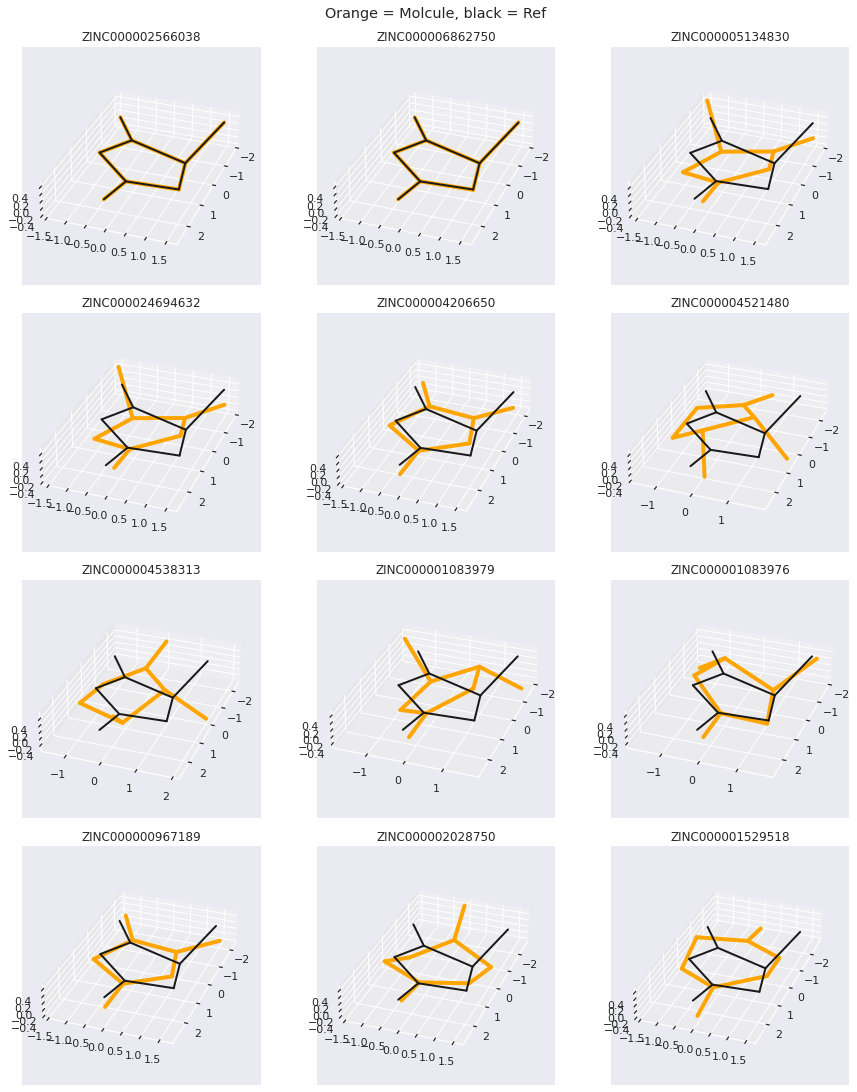

In [ ]:
#Change 'start' to plot the closest molecules to reference molecule, from 'start' index:
start = 0

plot_3d_molecule(mols[start:],
                 mols_bonds_idx[start:],
                 mols_data[start:],
                 12,                     #number of mols to plot
                 elev = 30,              #change azim and elev to rotate the plot (check here: https://i.stack.imgur.com/BnHAp.png)
                 azim = 20,
                 ref = [ref_mol, ref_bonds_idx]);

### 10. Conclusions:

1. The fisrt molecule is actually the reference molecule, which also appears in the test molecules.
2. The second molecule is also the reference molecule, under a different name.
3. Besides the first and second molecules, we can see a good geometrical similarity between the reference molecule and the molecules with smallest distance.
4. Distance metric is a good estimator for geometrical similirty

### 11. Clustering:

The second goal of the project was to cluster the test molecules.
The following data frame detail counts of each unique value in number of circles.

In [35]:
df = pd.DataFrame(np.unique(data['num_circles'], return_counts = True)).T
df.columns = ['Num_circles', 'Count']
df

,Num_circles,Count
0,-1,13
1,0,447
2,1,1057
3,2,299
4,4,11
5,6,1


The majority of molecules have 0, 1 or 2 circles, while the rest (25 molecules) have 4, 6 or unknown number of circles.
Because the number of circles is an important feature, I have splitted the data to 0, 1, 2 and "other" sub-groups in order to cluster each sub-group seperatly.

In [36]:
zero_circ_idx = np.where(mols_data['num_circles'] == 0)[0]

zero_circ_data = mols_data_scaled[zero_circ_idx]
zero_circ_mols = [mols[i] for i in zero_circ_idx]
zero_circ_bonds = [mols_bonds_idx[i] for i in zero_circ_idx]
zero_distances = distances[zero_circ_idx]

In [37]:
one_circ_idx = np.where(mols_data['num_circles'] == 1)[0]

one_circ_data = mols_data_scaled[one_circ_idx]
one_circ_mols = [mols[i] for i in one_circ_idx]
one_circ_bonds = [mols_bonds_idx[i] for i in one_circ_idx]
one_distances = distances[one_circ_idx]

In [38]:
two_circ_idx = np.where(mols_data['num_circles'] == 2)[0]

two_circ_data = mols_data_scaled[two_circ_idx]
two_circ_mols = [mols[i] for i in two_circ_idx]
two_circ_bonds = [mols_bonds_idx[i] for i in two_circ_idx]
two_distances = distances[two_circ_idx]

In [39]:
other_circ_idx = np.where((mols_data['num_circles'] != 0) &
                          (mols_data['num_circles'] != 1) &
                          (mols_data['num_circles'] != 2))[0]

other_circ_data = mols_data_scaled[other_circ_idx]
other_circ_mols = [mols[i] for i in other_circ_idx]
other_circ_bonds = [mols_bonds_idx[i] for i in other_circ_idx]
other_distances = distances[other_circ_idx]

###### *Clustering Models performance assessment*

There are 2 issues regarding the clustering process:
1. Which model perform the best?
2. How many clusters are required?

To answer those 2 questions, the performance of each model was done by:
For each model, for each sub-group, do the following:
1. Choose a clustering model.
2. For each subgroup, cluster the data, with n number of cluster, where n ranges from 2 to 100.
3. For each iteration, compute the average of each cluster variance.
4. For each sub-group, plot mean of variance per number of cluster.

The following plots represent the above process.

In [52]:
zero_agglomerative_result = calc_mean_of_var_per_num_clusters(zero_circ_data, zero_distances, AgglomerativeClustering, linkage = 'single')
one_agglomerative_result = calc_mean_of_var_per_num_clusters(one_circ_data, one_distances, AgglomerativeClustering, linkage = 'single')
two_agglomerative_result = calc_mean_of_var_per_num_clusters(two_circ_data, two_distances, AgglomerativeClustering, linkage = 'single')
other_agglomerative_result = calc_mean_of_var_per_num_clusters(other_circ_data, other_distances, AgglomerativeClustering, linkage = 'single')

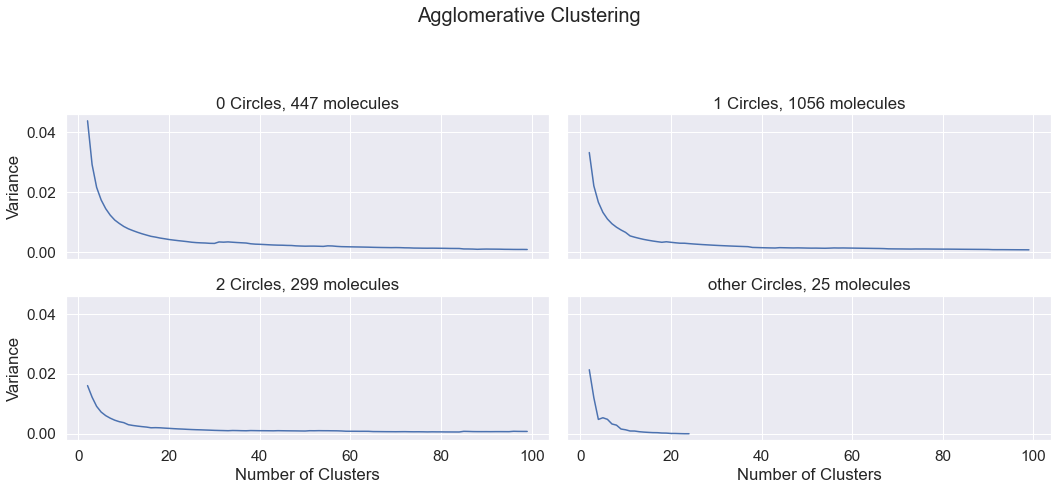

In [53]:
agc_results = [zero_agglomerative_result, one_agglomerative_result, two_agglomerative_result, other_agglomerative_result]
title = 'Agglomerative Clustering'
    
plot_var_vs_num_clusters(agc_results, title)

In [54]:
zero_kmeans_result = calc_mean_of_var_per_num_clusters(zero_circ_data, zero_distances, KMeans)
one_kmeans_result = calc_mean_of_var_per_num_clusters(one_circ_data, one_distances, KMeans)
two_kmeans_result = calc_mean_of_var_per_num_clusters(two_circ_data, two_distances, KMeans)
other_kmeans_result = calc_mean_of_var_per_num_clusters(other_circ_data, other_distances, KMeans)

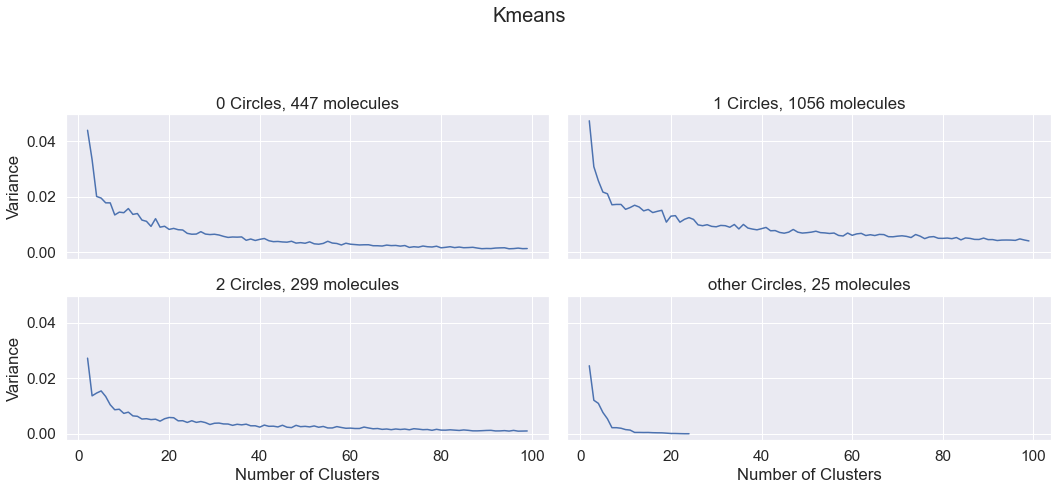

In [55]:
kms_results = [zero_kmeans_result, one_kmeans_result, two_kmeans_result, other_kmeans_result]
title = 'Kmeans'
    
plot_var_vs_num_clusters(kms_results, title)

In [56]:
zero_gmm_result = calc_mean_of_var_per_num_clusters(zero_circ_data, zero_distances, GaussianMixture)
one_gmm_result = calc_mean_of_var_per_num_clusters(one_circ_data, one_distances, GaussianMixture)
two_gmm_result = calc_mean_of_var_per_num_clusters(two_circ_data, two_distances, GaussianMixture)
other_gmm_result = calc_mean_of_var_per_num_clusters(other_circ_data, other_distances, GaussianMixture)

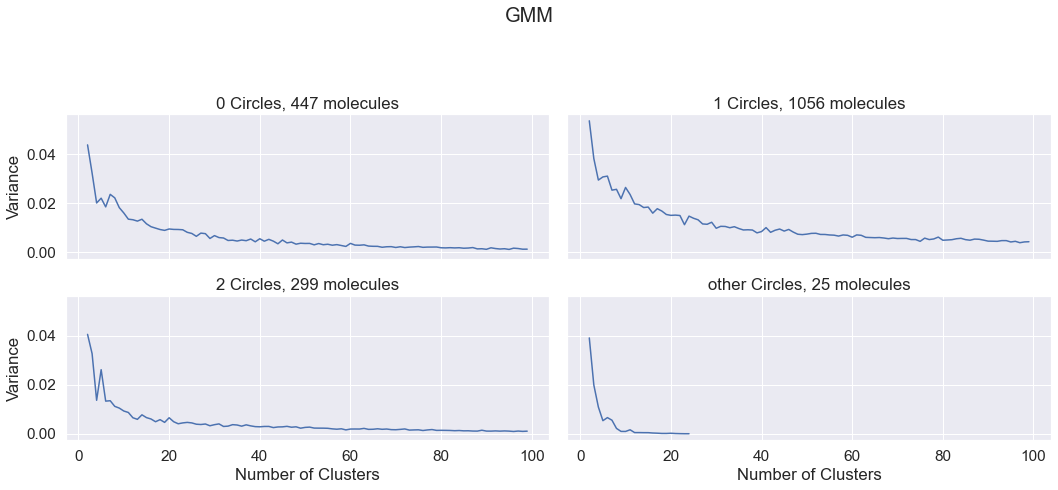

In [57]:
gmm_results = [zero_gmm_result, one_gmm_result, two_gmm_result, other_gmm_result]
title = 'GMM'
    
plot_var_vs_num_clusters(gmm_results, title)

The general behaviour of each clustering model is similar - Mean of variance has a distinguishable "elbow effect" at around 10 clusters, reducing as number of cluster increases.

Looking at the plots of each model, Agglomerative Clustering seems to have a "stable" behavior over K-means and GMM, which is why I have decided to continue with it.

n_clusters = 10 seems a viable choice.

In [ ]:
data_splits = [zero_circ_data, one_circ_data, two_circ_data, other_circ_data]
distances_splits = [zero_distances, one_distances, two_distances, other_distances]

Violin plots of the variance of distances per cluster. Each plot represent different number of circle.

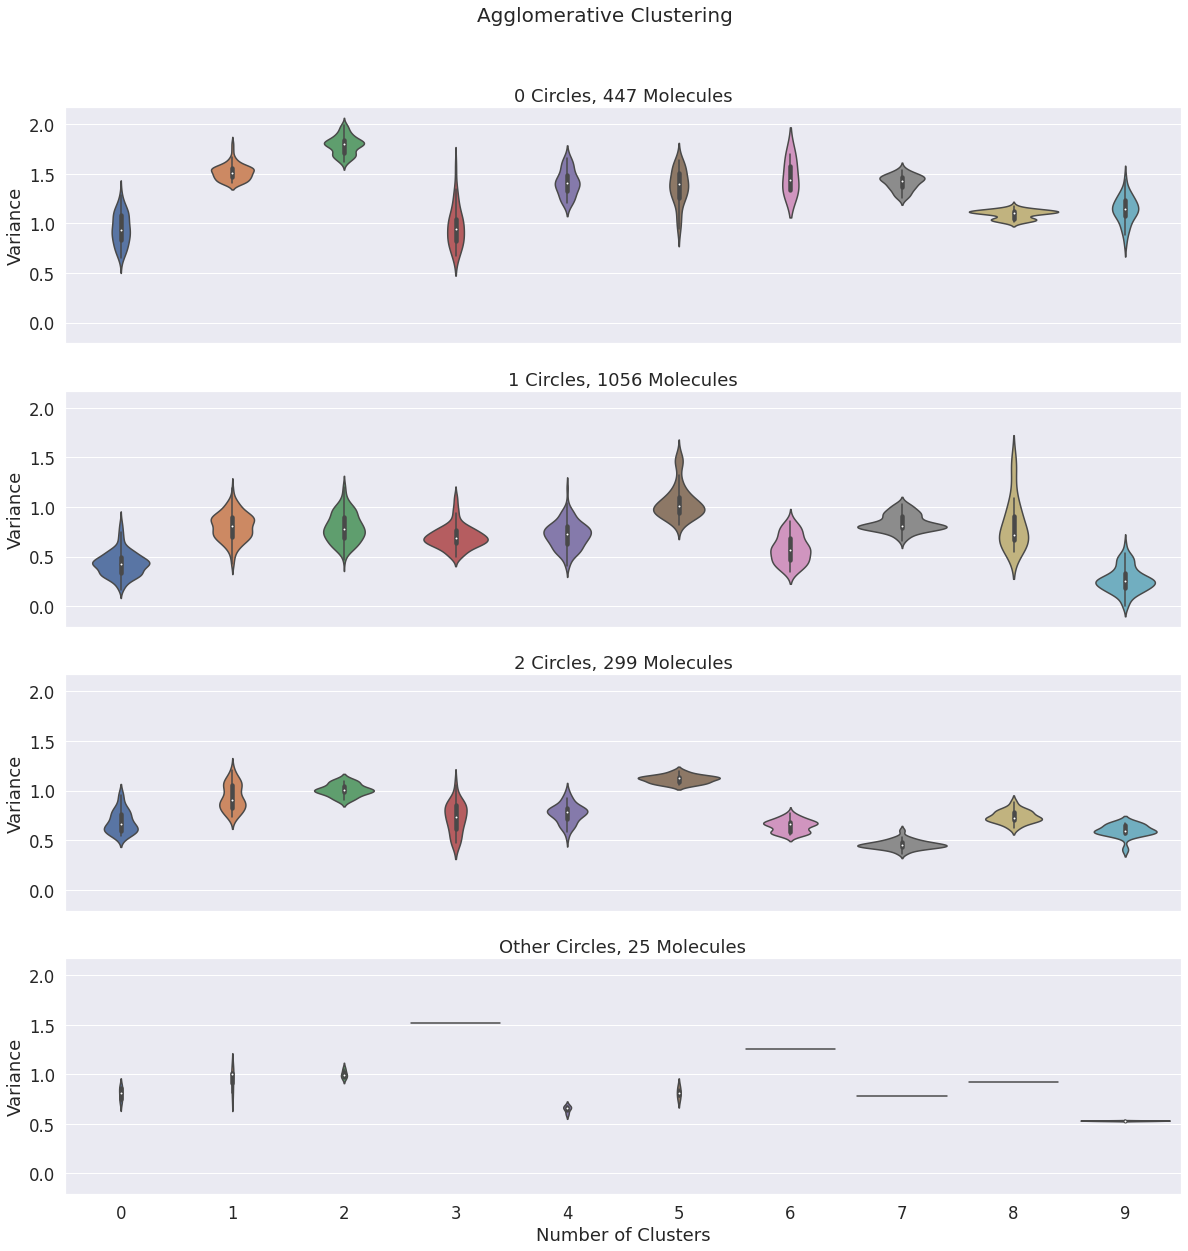

In [ ]:
agc = AgglomerativeClustering(n_clusters= 10)

plot_violins(data_splits, distances_splits, agc, 'Agglomerative Clustering')

Dendrogram plotting for each sub-group:

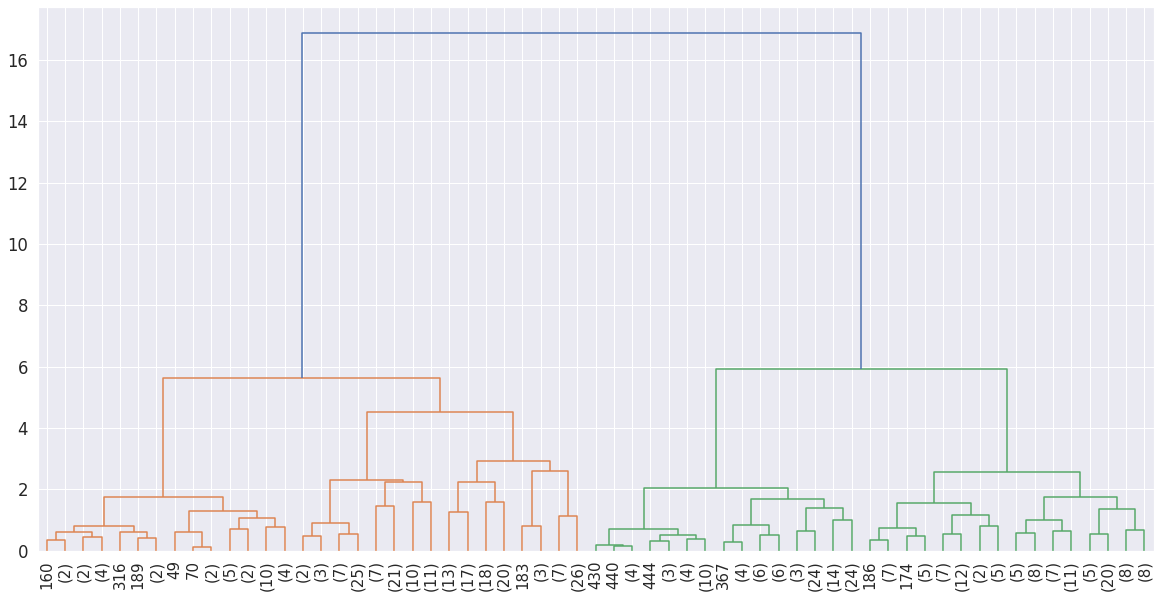

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(zero_circ_data)
plot_dendrogram(model, truncate_mode="level", p=5, leaf_font_size=15)

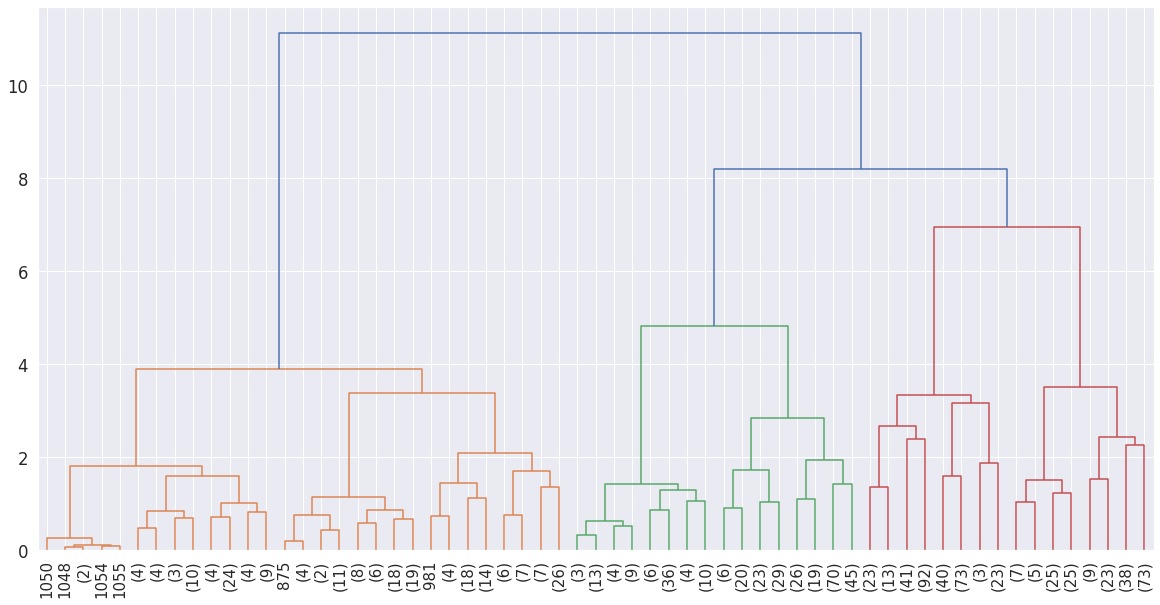

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(one_circ_data)
plot_dendrogram(model, truncate_mode="level", p=5, leaf_font_size=15)

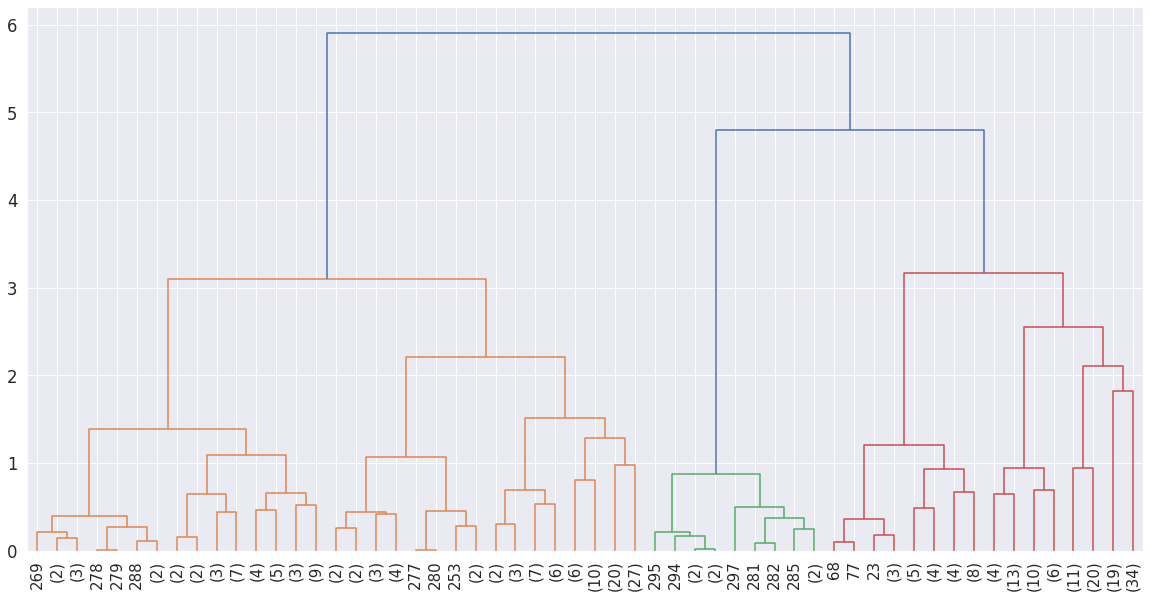

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(two_circ_data)
plot_dendrogram(model, truncate_mode="level", p=5, leaf_font_size=15)


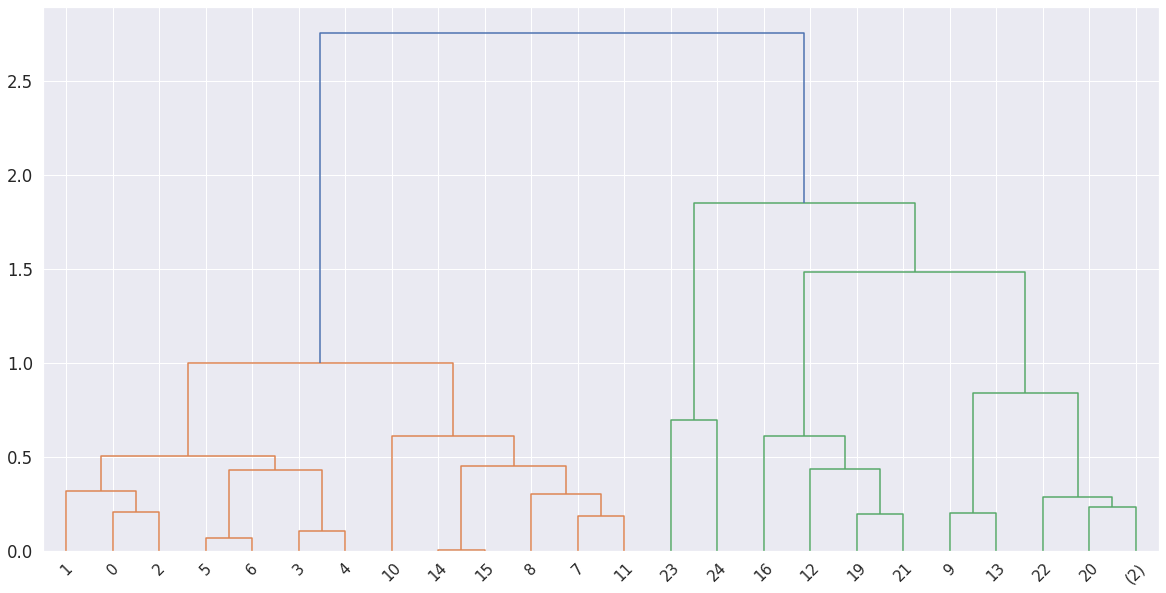

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(other_circ_data)
plot_dendrogram(model, truncate_mode="level", p=5, leaf_font_size=15)

### 12. Finel Data Frame:

Generate finel dataframe, for n_clusters ranges from 4 to 12:

In [ ]:
finel_df = mols_data.loc[:, ['molecule_name', 'num_circles']].copy(deep = False)
finel_df['Distance from ref'] = distances
finel_df.loc[other_circ_idx, 'num_circles'] = -1
finel_df.sort_values(['num_circles', 'Distance from ref'], inplace = True)

In [ ]:
for n_clusters in range(4,14,2):

    finel_df[f'{n_clusters} clusters'] = 0
    
    agc = AgglomerativeClustering(n_clusters, linkage = 'single')
    
    for idx in [zero_circ_idx, one_circ_idx, two_circ_idx, other_circ_idx]:
        
        clusters = agc.fit_predict(data.loc[idx].drop(['molecule_name', 'num_circles'], axis = 1))

        finel_df.loc[idx, f'{n_clusters} clusters'] = clusters

In [ ]:
finel_df

,molecule_name,num_circles,Distance from ref,4 clusters,6 clusters,8 clusters,10 clusters,12 clusters
354,ZINC000108281243,-1,0.528466,1,5,5,5,11
360,ZINC000034536992,-1,0.531898,1,1,0,3,3
362,ZINC000224622274,-1,0.533420,1,1,0,8,8
480,ZINC000032195219,-1,0.600678,0,3,1,1,1
581,ZINC000032195216,-1,0.657393,1,1,0,8,8
...,...,...,...,...,...,...,...,...
1477,ZINC000002266437,2,1.137326,1,2,2,1,2
1491,ZINC000042191865,2,1.158154,1,2,2,1,2
1496,ZINC000000198820,2,1.176859,1,2,2,1,2
1504,ZINC000005131657,2,1.193227,1,2,2,1,2


Export finel data frame to CSV:

In [ ]:
finel_df.to_csv(path + r'/Finel Clustering.csv')

### 13. View molecules by clustering:

In [ ]:
#Selecet number of circles (-1, 0, 1, 2)
n_circles = 1

#Select number of clusters:
n_clusters = 10

#Select cluster number:
cluster = 2

#Or select the cluster with the reference molecule (set True/False):
ref = False
if ref:
  cluster = finel_df.loc[finel_df['molecule_name'] == 'ZINC000002566038', f'{n_clusters} clusters'][0]
  n_circles = 1

idx = finel_df[(finel_df[f'{n_clusters} clusters'] == cluster) & (finel_df['num_circles'] == n_circles)].index

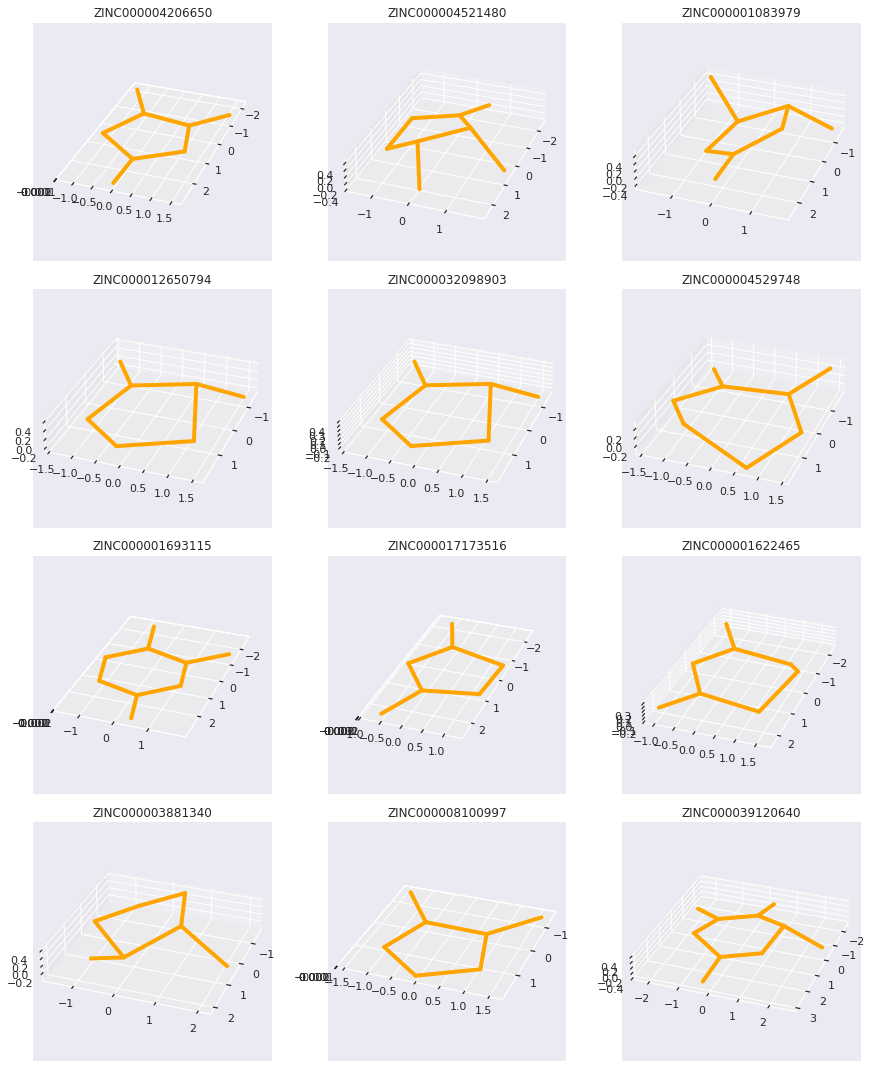

In [ ]:
#Change 'start' to plot the closest molecules to reference molecule, from 'start' index:
start = 0

plot_3d_molecule([mols[i] for i in idx[start:]],
                 [mols_bonds_idx[i] for i in idx[start:]],
                 mols_data.loc[idx[start:],:],
                 12,                    #number of mols to plot
                 elev = 30,             #change azim and elev to rotate the plot (check here: https://i.stack.imgur.com/BnHAp.png)
                 azim = 20)